In [46]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import pandas_market_calendars as mcal

import warnings
warnings.filterwarnings('ignore')

In [2]:
def nyse_holidays():
    nyse = mcal.get_calendar('NYSE')
    holidays = nyse.holidays()
    nyse_holidays = holidays.holidays
    
    return nyse_holidays

# shift dates if they fall on a weekend/trading holiday
def get_prev_business_date(date, holidays):
    if date.isoweekday() in set((6, 7)):
        #if date falls on a weekend, move the date back
        date -= pd.offsets.BDay(n = date.isoweekday() % 5)
    elif date in holidays:
        #if date is a NYSE trading holiday, move the date back
        date -= pd.offsets.BDay(n=1)  # get prev day
        # now if the new date is on a weekend, move it back 
        if date.isoweekday() in set((6, 7)):
            date -= pd.offsets.BDay(n = date.isoweekday() % 5)

    return date

In [3]:
#Load Price Data
def get_oil_prices():
    wd = os.getcwd()

    df = pd.read_excel(wd+'/Data/'+'WTI.xlsx')
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].dt.strftime('%m-%d-%Y')
    df.set_index('Date', inplace=True)
    
    return df

In [4]:
def get_ma(df, column, freq='monthly'):
    df[df.columns[column] + '_temp'] = df[df.columns[column]]
    
    if freq=='monthly':
        window = 22
    elif freq=='biweekly':
        window = 10
    
    for i in range(0, len(df[df.columns[column]])-window):
        df.iloc[i, column] = np.mean(df.iloc[i:i+window, -1])
        
    drop_col_name = df.columns[column] + '_temp'
    df = df.loc[:, ~df.columns.isin([drop_col_name])]
    
    return df

In [5]:
#Load Features

def get_features(df, sma=True):
    if sma:
        df = get_ma(df, 0, 'monthly')
    
    wd = os.getcwd()
    xlsx_files = glob.glob(os.path.join(wd, 'Data', "*.xlsx"))
    holidays = nyse_holidays()
    daily_data = ['DowJones', 'SPX', 'USDEUR', 'DAX', 'NG1', 'Nikkei', 'HangSeng', 'GT10']

    for file in xlsx_files:
        data_name = file.split("\\")[-1].split('.')[0]
        data_name = data_name.replace(" ", "_")

        if data_name == 'WTI':
            continue

        df_temp = pd.read_excel(file)
        df_temp['Date'] = pd.to_datetime(df_temp['Date'])
        #print(data_name)
        if data_name in daily_data:
            df_temp['Date'] = df_temp['Date'].dt.strftime('%m-%d-%Y')
            df_temp.set_index('Date', inplace=True)
        else:
            df_temp['Artificial Date'] = df_temp['Date'].apply(lambda x: get_prev_business_date(x, holidays))
            df_temp['Artificial Date'] = df_temp['Artificial Date'].dt.strftime('%m-%d-%Y')
            df_temp = df_temp.drop(columns=['Date'])
            df_temp.set_index('Artificial Date', inplace=True)

        try:
            df[df_temp.columns[0] + '_' + data_name] = df_temp[df_temp.columns[0]]
        except ValueError:
            print(data_name, "Error")

    #backfill data for other frequencies
    df.fillna(method='bfill', inplace=True)
    idx = list(df.index).index('12-31-2020')
    df = df.iloc[idx:,:]
    
    return df



In [6]:
def get_raw_data(df, freq = 'daily'):
    if freq == 'weekly':
        df = df.iloc[::5, :]
    
    #Add Sign and returns Data point
    df['PX_Sign'] = np.sign(df['PX_LAST'] - df['PX_LAST'].shift(-1))
    df.loc[df.PX_Sign == 0, 'PX_Sign'] = int(1)
    df['Returns'] = df['PX_LAST']/df['PX_LAST'].shift(-1) - 1
    
    return df
    

In [7]:
def plot_prices_graph(df):
    ax = df_t[df_t.columns[0]][::-1].plot()
    ax.set_ylabel("WTI Price")
    ax.set_title('WTI Price (1990-2021)')

In [8]:
prices = ['PX_LAST']
classification = ['PX_Sign']
returns = ['Returns']

In [9]:
#Dict for frequency adjustment
cols_freq = {
    'PX_LAST':"daily",
    'PX_VOLUME':"daily",
    'PX_LAST_DowJones':"daily",
    'PX_MID_GT10':"daily",
    'PX_LAST_HangSeng':"daily",
    'PX_LAST_Nikkei':"daily",
    'PX_LAST_SPX':"daily",
    'PX_LAST_USDEUR':"daily",
    'PX_LAST_NG1':"daily",
    'PX_LAST_DAX':"daily",
    'PX_LAST_US_daily_prod':"monthly",
    'PX_LAST_Cass_Freight_Rates':"monthly",
    'PX_LAST_Canada_daily_prod':"monthly",
    'PX_LAST_Russia_daily_prod':"monthly",
    'PX_LAST_OPEC_daily_prod':"monthly",
    'PX_LAST_US_Inflation':"monthly",
    'PX_LAST_Europe_Inflation':"monthly",
    'PX_LAST_Europe_IndProd_exConstruction':"monthly",
    'PX_LAST_Russia_Industrial_Production':"monthly",
    'PX_LAST_US_IndProd_Index':"monthly",
    'PX_LAST_China_GDP':"quarterly",
    'PX_LAST_Germany_GDP':"quarterly",
    'PX_LAST_Japan_GDP':"quarterly",
    'PX_LAST_Russia_GDP':"quarterly",
    'PX_LAST_US_GDP':"quarterly",
    'PX_Sign':'daily',
    'Returns':'daily'
}

In [10]:
def daily_lag(df, column, lag):
    lag = lag+1
    if column==0:
        for i in range(1, lag):
            #creating new column here since column==0 is target
            
            df[df.columns[column] + '_t-' + str(i)] = df[df.columns[column]].shift(-i)
            cols_freq[df.columns[column]+'_t-'+str(i)] = "daily"
    else:
        for i in range(1, lag):
            #replacing old column here and renaming
            df[df.columns[column]] = df[df.columns[column]].shift(-i)
            df.rename(columns={df.columns[column]:df.columns[column]+'_t-'+str(i)}, inplace=True)
            new_col = df.columns[column]
            cols_freq[new_col] = "daily"
    
    return df


def ma(df, column, col_freq = "monthly", freq='daily'):
    if col_freq == "monthly":
        #creating temp column to get values
        df[df.columns[column] + '_temp'] = df[df.columns[column]]
        
        if freq == 'daily':
            window = 22
        elif freq == 'weekly':
            window = 4
        
        for i in range(0, len(df[df.columns[column]])-window):
            df.iloc[i, column] = np.mean(df.iloc[i:i+window, -1])
        
        #dropping temp column
        drop_col_name = df.columns[column] + '_temp'
        df = df.loc[:, ~df.columns.isin([drop_col_name])]
        
        #renaming column to indicate moving average
        df.rename(columns={df.columns[column]:df.columns[column]+'_SMA22'}, inplace=True)
        cols_freq[df.columns[column]] = "monthly"
    elif col_freq == "quarterly":
        #creating temp column to get values
        df[df.columns[column] + '_temp'] = df[df.columns[column]]
        
        if freq == 'daily':
            window = 65
        elif freq == 'weekly':
            window = 13
        
        for i in range(0, len(df[df.columns[column]])-window):
            df.iloc[i, column] = np.mean(df.iloc[i:i+window, -1])
        
        #dropping temp column
        drop_col_name = df.columns[column] + '_temp'
        df = df.loc[:, ~df.columns.isin([drop_col_name])]
        
        #renaming column to indicate moving average
        df.rename(columns={df.columns[column]:df.columns[column]+'_SMA65'}, inplace=True)
        cols_freq[df.columns[column]] = "quarterly"
    
    return df


def lag_data(df, column, col_freq = "monthly", freq='daily'):
    if col_freq == "monthly":
        if freq == 'daily':
            lag = 22
        elif freq == 'weekly':
            lag = 4
        #replacing old column and renaming
        df[df.columns[column]] = df[df.columns[column]].shift(-lag)
        df.rename(columns={df.columns[column]:df.columns[column]+'_M'}, inplace=True)
    elif col_freq == "quarterly":
        if freq == 'daily':
            lag = 65
        elif freq == 'weekly':
            lag = 13
        #replacing old column and renaming
        df[df.columns[column]] = df[df.columns[column]].shift(-lag)
        df.rename(columns={df.columns[column]:df.columns[column]+'_Q'}, inplace=True)
    else:
        raise ValueError("Frequency invalid")
    
    return df

def get_lag_ma_data(df, daily_lags = 1, cols_freq=cols_freq, freq='daily'):
    for i in range(len(df.columns)):
        column_name = df.columns[i]
        #print(column_name)
        if cols_freq[column_name] == 'daily':
            df = daily_lag(df, i, daily_lags)
        else:
            df = lag_data(df, i, cols_freq[column_name], freq)
            df = ma(df, i, cols_freq[column_name], freq)
            
    return df

In [11]:
def one_day_change(df, column, freq):
    #creating new column here, will drop old column later in get_diffs
    if freq=='daily':
        df[df.columns[column] + '_1D_change'] = df[df.columns[column]] - df[df.columns[column]].shift(-1)
    elif freq=='weekly':
        df[df.columns[column] + '_1W_change'] = df[df.columns[column]] - df[df.columns[column]].shift(-1)

    return df

def two_week_change(df, column, freq):
    #creating new column here, will drop old column later in get_diffs
    if freq=='daily':
        df[df.columns[column] + '_2W_change'] = df[df.columns[column]] - df[df.columns[column]].shift(-10)
    elif freq=='weekly':
        df[df.columns[column] + '_2W_change'] = df[df.columns[column]] - df[df.columns[column]].shift(-2)
    
    return df

def one_month_change(df, column, freq):
    #creating new column here, will drop old column later in get_diffs
    if freq=='daily':
        df[df.columns[column] + '_1M_change'] = df[df.columns[column]] - df[df.columns[column]].shift(-22)
    elif freq=='weekly':
        df[df.columns[column] + '_1M_change'] = df[df.columns[column]] - df[df.columns[column]].shift(-4)
    return df

def get_diffs(df, target, cols_freq=cols_freq, freq='daily', drop=True):
    cols = []
    for i in range(1, len(df.columns)):
        column_name = df.columns[i]
        #collecting old columns to drop later
        cols.append(column_name)
        
        if cols_freq[column_name] == 'daily':
            df = one_day_change(df, i, freq)
            df = two_week_change(df, i, freq)
            df = one_month_change(df, i, freq)
        elif cols_freq[column_name] == 'monthly':
            df = two_week_change(df, i, freq)
            df = one_month_change(df, i, freq)
        elif cols_freq[column_name] == 'quarterly':
            df = one_month_change(df, i, freq)
        
    #dropping old columns
    target_lagged = df.columns[0] + '_t-1'
    cols.remove(target_lagged)
    #print(cols)
    df = df.loc[:, ~df.columns.isin(cols)]
    
    return df

In [12]:
def make_regime(df, end, start=0):
    if start==0 and end==0:
        return df
    
    if start!=0:
        st_idx = list(df.index).index(start)
    else:
        st_idx = 0
    end_idx = list(df.index).index(end)
    df_reg = df.iloc[st_idx:end_idx,:]
    return df_reg

In [13]:
def do_pca(feature_set):
    n = len(feature_set)
    d = len(feature_set.columns)
    
    x = feature_set.values #numpy array
    x_scaled = StandardScaler().fit_transform(x)
    feature_set = pd.DataFrame(x_scaled)
    
    k = int(round(d/3, 0)) #no. of reduced features needed
    w0 = np.random.randn(k, d) #Y is (n x d) dimensional
    wt = w0
    I = 10 #no. of iterations for alternating minimisation
    residuals_am = np.zeros(I)

    for t in range(I):
        wt_1 = wt
        gram_w = np.matmul(wt_1, wt_1.T)
        gram_w_inv = np.linalg.inv(gram_w)
        xt = np.zeros((n,k))
        for i in range(n):
            xt[i] = np.matmul(feature_set.iloc[i].values, np.matmul(wt_1.T, gram_w_inv))

        gram_x = np.matmul(xt.T, xt)
        gram_x_inv = np.linalg.inv(gram_x)
        wt = np.zeros((k,d))
        for j in range(d):
            wt[:,j] = np.matmul(np.matmul(gram_x_inv, xt.T), feature_set.iloc[:,j])

        residuals_am[t] = np.linalg.norm(feature_set.values-np.matmul(xt, wt))
        
    return xt, k, residuals_am

In [14]:
def get_final_data(df, features, regime, target=classification, freq='daily', pca=False):
    if target != prices:
        features = ['PX_LAST'] + features
    
    df_trial = get_lag_ma_data(df[target + features], freq=freq)
    df_trial = get_diffs(df_trial, target, freq=freq)
    
    df_trial = df_trial.dropna()
    df_trial = df_trial[::-1]
    
    df_reg = make_regime(df_trial, end=regime[1], start=regime[0])
    
    df_target = df_reg[target]
    df_features_raw = df_reg.iloc[:, 1:]
    
    if pca:
        d = len(df_features_raw.columns)
        xt, k, res = do_pca(df_features_raw)
        df_features = pd.DataFrame(xt)
        df_features.index = df_features_raw.index
        print("PCA reduced features from {} to {}".format(d, k))
        print("Error = {}".format(res[-1]))
    else:
        df_features = df_features_raw.copy()
    
    if target == classification:
        df_target = df_target.astype(int)
    
    return df_target, df_features

In [15]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import RobustScaler
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit

def get_data_splits(target, features):
    train_n = int(len(target) * 0.8)
    train_x = features[:train_n].to_numpy()
    train_y = target[:train_n].to_numpy()
    test_x = features[train_n:].to_numpy()
    test_y = target[train_n:].to_numpy()

    splits = TimeSeriesSplit(n_splits=100)

    split_train_x = []
    split_val_x = []
    split_train_y = []
    split_val_y = []

    for train_index, val_index in splits.split(train_x):
        split_train_x.append(train_x[train_index])
        split_train_y.append(train_y[train_index])
        split_val_x.append(train_x[val_index])
        split_val_y.append(train_y[val_index])
        
    split_data = [split_train_x, split_train_y, split_val_x, split_val_y]
    train_data = [train_x, train_y]
    test_data = [test_x, test_y]
    
    return split_data, train_data, test_data

### Classification Models

In [16]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

def svc_hinge(split_data, iters=1000):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    lambdas = np.arange(0.001, 0.101, 0.02)
    Hloss = []
    Rh = []
    count = 0
    
    for lam in lambdas:
        scaler = RobustScaler()
        clf = svm.LinearSVC(penalty='l2', loss='hinge', fit_intercept=True,
                            C=(1/lam), max_iter=iters, random_state=42)
        acc = []
        
        for i in range(len(split_train_x)):
            #wrapped_model = TransformedTargetRegressor(regressor=clf, transformer=RobustScaler())
            #model = wrapped_model.fit(split_train_x[i], split_train_y[i].reshape(len(split_train_y[i])))
            
            scaled_fit_train = scaler.fit(split_train_x[i])
            split_train_x[i] = scaled_fit_train.transform(split_train_x[i])
            split_val_x[i] = scaled_fit_train.transform(split_val_x[i])
            
            model = clf.fit(split_train_x[i], split_train_y[i].reshape(-1,1))
            pred = model.predict(split_val_x[i])
            acc.append(np.mean(pred != split_val_y[i]))
            count+=1
            #print(count)
        Hloss.append(np.mean(acc))
        Rh.append(lam)
    l_star = Rh[np.argmin(Hloss)]
    print('Lambda* = {}'.format(l_star))
    print('SVM Validation Error Rate = {}'.format(Hloss[np.argmin(Hloss)]))
    return Hloss, Rh, l_star

def svc_hinge_test(train_data, test_data, l_star, iters=10000):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    scaler = RobustScaler()
    scaled_fit_train = scaler.fit(train_x)
    
    train_x_std = scaled_fit_train.transform(train_x)
    test_x_std = scaled_fit_train.transform(test_x)
    
    
    model = svm.LinearSVC(penalty='l2', loss='hinge', fit_intercept=True,
                            C=(1/l_star), max_iter=iters, random_state=42)
    
    train_y = train_y.reshape(-1,1)
    model.fit(train_x_std, train_y)
    pred = model.predict(test_x_std)
    mse = np.mean(pred!=test_y)
    
    return pred, mse

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

def decision_tree(split_data):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    maxnodes = np.arange(3, 18, 1)
    maxnodes_misclas = []
    
    for maxnode in maxnodes:
        misclas = []
        
        for i in range(len(split_train_x)):
            model = tree.DecisionTreeClassifier(random_state=42, max_leaf_nodes = maxnode)
            model = model.fit(split_train_x[i], split_train_y[i])
            yhat = model.predict(split_val_x[i])
            misclas.append(np.mean(yhat!=split_val_y[i]))

        maxnodes_misclas.append(np.mean(misclas))
    
    best_nodes = maxnodes[np.argmin(maxnodes_misclas)]
    print('Best Max Nodes = {}'.format(best_nodes))
    print('Decision Tree Validation Error Rate = {}'.format(maxnodes_misclas[np.argmin(maxnodes_misclas)]))
    
    return maxnodes_misclas, best_nodes

def decision_tree_test(train_data, test_data, maxnodes):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    tr_model = tree.DecisionTreeClassifier(random_state=2, max_leaf_nodes = maxnodes)
    tr_model = tr_model.fit(train_x, train_y)
    pred = tr_model.predict(test_x)
    error = np.mean(pred!=test_y)
    
    return pred, error



In [18]:
from sklearn.linear_model import LogisticRegression

def logistic(split_data, iters=1000):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    lambdas = np.arange(0.01, 1.01, 0.20)
    Lloss = []
    Rl = []
    count = 0
    
    for lam in lambdas:
        scaler = RobustScaler()
        clf = LogisticRegression(penalty='l2', C=(1/lam), max_iter=iters, random_state=42,
                            fit_intercept=True)
        acc = []
        
        for i in range(len(split_train_x)):
            #wrapped_model = TransformedTargetRegressor(regressor=clf, transformer=RobustScaler())
            #model = wrapped_model.fit(split_train_x[i], split_train_y[i].reshape(len(split_train_y[i])))
            
            scaled_fit_train = scaler.fit(split_train_x[i])
            split_train_x[i] = scaled_fit_train.transform(split_train_x[i])
            split_val_x[i] = scaled_fit_train.transform(split_val_x[i])
            
            model = clf.fit(split_train_x[i], split_train_y[i].reshape(-1,1))
            pred = model.predict(split_val_x[i])
            acc.append(np.mean(pred != split_val_y[i]))
            count+=1
            #print(count)
        Lloss.append(np.mean(acc))
        Rl.append(lam)
    l_star = Rl[np.argmin(Lloss)]
    print('Lambda* = {}'.format(l_star))
    print('Logistic Validation Error Rate = {}'.format(Lloss[np.argmin(Lloss)]))
    return Lloss, Rl, l_star

def logistic_test(train_data, test_data, l_star, iters=1000):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    scaler = RobustScaler()
    scaled_fit_train = scaler.fit(train_x)
    
    train_x_std = scaled_fit_train.transform(train_x)
    test_x_std = scaled_fit_train.transform(test_x)
    
    model = LogisticRegression(penalty='l2', C=(1/l_star), max_iter=iters, random_state=42, 
                             fit_intercept=True)
    
    train_y = train_y.reshape(-1,1)
    model.fit(train_x_std, train_y)
    pred = model.predict(test_x_std)
    mse = np.mean(pred!=test_y)
    
    return pred, mse

### Regression Models

In [97]:
def lasso(split_data, alphas=np.arange(0.05, 1.01, 0.05)):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    alpha_mse = []
    
    for alpha in alphas:
        transformer = RobustScaler
        model = linear_model.Lasso(alpha=alpha)
        mse = []
        for i in range(len(split_train_x)):
            wrapped_model = TransformedTargetRegressor(regressor=model, transformer=RobustScaler())
            wrapped_model.fit(split_train_x[i], split_train_y[i])
            yhat = wrapped_model.predict(split_val_x[i])
            mse.append(np.mean((yhat-split_val_y[i])**2))
        alpha_mse.append(np.mean(mse))
    a_star = alphas[np.argmin(alpha_mse)]
    print('Lasso Alpha* = {}'.format(alphas[np.argmin(alpha_mse)]))
    print('Lasso Validation RMSE = {}'.format(np.sqrt(alpha_mse[np.argmin(alpha_mse)])))
    return alpha_mse, a_star

def lasso_test(train_data, test_data, alpha):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    model = linear_model.Lasso(alpha=alpha)
    wrapped_model = TransformedTargetRegressor(regressor=model, transformer=RobustScaler())
    wrapped_model.fit(train_x, train_y)
    train_yhat = wrapped_model.predict(train_x)
    pred = wrapped_model.predict(test_x)
    
    train_mse = np.mean((train_yhat-train_y)**2)
    test_mse = np.mean((pred-test_y)**2)
    
    return pred, test_mse, train_mse

In [20]:
def huber(split_data):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    alphas = np.arange(0.05, 1.01, 0.05)
    alpha_mse = []
    
    for alpha in alphas:                     
        transformer = RobustScaler
        model = linear_model.HuberRegressor(alpha=alpha)
        mse = []
        for i in range(len(split_train_x)):
            wrapped_model = TransformedTargetRegressor(regressor=model, transformer=RobustScaler())
            wrapped_model.fit(split_train_x[i], split_train_y[i])
            yhat = wrapped_model.predict(split_val_x[i])
            mse.append(np.mean((yhat-split_val_y[i])**2))
        alpha_mse.append(np.mean(mse))
    a_star = alphas[np.argmin(alpha_mse)]
    print('Huber Alpha* = {}'.format(a_star))
    print('Huber Validation RMSE = {}'.format(np.sqrt(alpha_mse[np.argmin(alpha_mse)])))
    return alpha_mse, a_star

def huber_test(train_data, test_data, alpha):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    model = linear_model.HuberRegressor(alpha=alpha)
    wrapped_model = TransformedTargetRegressor(regressor=model, transformer=RobustScaler())
    wrapped_model.fit(train_x, train_y)
    train_yhat = wrapped_model.predict(train_x)
    pred = wrapped_model.predict(test_x)
    
    train_mse = np.mean((train_yhat-train_y)**2)
    test_mse = np.mean((pred-test_y)**2)
    
    return pred, test_mse, train_mse

In [21]:
from sklearn.ensemble import RandomForestRegressor

def RF_regressor(split_data):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    estimators = np.arange(70, 130, 10)
    estimator_mse = []
    
    for estimator in estimators:
        model = RandomForestRegressor(n_estimators=estimator)
        mse = []
        model.fit(split_train_x[-1], split_train_y[-1])
        yhat = model.predict(split_val_x[-1])
        mse.append(np.mean((yhat-split_val_y[-1])**2))
        estimator_mse.append(np.mean(mse))
    best_est = estimators[np.argmin(estimator_mse)]
    print('Random Forest Efficient Estimator = {}'.format(best_est))
    print('Random Forest Validation RMSE = {}'.format(np.sqrt(estimator_mse[np.argmin(estimator_mse)])))
    return estimator_mse, best_est

def RF_regressor_test(train_data, test_data, best_est):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    model = RandomForestRegressor(n_estimators=best_est)
    model.fit(train_x, train_y)
    train_yhat = model.predict(train_x)
    pred = model.predict(test_x)
    
    train_mse = np.mean((train_yhat-train_y)**2)
    test_mse = np.mean((pred-test_y)**2)
    
    return pred, test_mse, train_mse

In [48]:
import xgboost as xgb

def XGBoost(split_data):
    split_train_x = split_data[0]
    split_train_y = split_data[1]
    split_val_x = split_data[2]
    split_val_y = split_data[3]
    
    estimators = np.arange(50, 1000, 50)
    estimator_mse = []
    
    for estimator in estimators:
        print(estimator)
        transformer = RobustScaler
        model = xgb.XGBRegressor(n_estimators=estimator, subsample=1.0)
        mse = []
        
        for i in range(len(split_train_x)):
            wrapped_model = TransformedTargetRegressor(regressor=model, transformer=RobustScaler())
            wrapped_model.fit(split_train_x[i], split_train_y[i])
            yhat = wrapped_model.predict(split_val_x[i])
            mse.append(np.mean((yhat-split_val_y[i])**2))
        estimator_mse.append(np.mean(mse))
    best_est = estimators[np.argmin(estimator_mse)]
    print('Efficient Estimator = {}'.format(best_est))
    print('XGBoost Validation RMSE = {}'.format(np.sqrt(estimator_mse[np.argmin(estimator_mse)])))
    return estimator_mse, best_est

def XGBoost_test(train_data, test_data, best_est=100):
    train_x = train_data[0]
    train_y = train_data[1]
    test_x = test_data[0]
    test_y = test_data[1]
    
    model = xgb.XGBRegressor(n_estimators=best_est, subsample=1.0)
    wrapped_model = TransformedTargetRegressor(regressor=model, transformer=RobustScaler())
    wrapped_model.fit(train_x, train_y)
    train_yhat = wrapped_model.predict(train_x)
    pred = wrapped_model.predict(test_x)
    
    train_rmse = mean_squared_error(train_y, train_yhat, squared=False)
    test_rmse = mean_squared_error(test_y, pred, squared=False)
    #train_mse = np.mean((train_yhat-train_y)**2)
    #test_mse = np.mean((pred-test_y)**2)
    
    return pred, test_rmse, train_rmse

In [23]:
def classification_models(features, regime_period, freq='daily', pca=False):
    if freq == 'daily':
        regime = regime_period[0]
    elif freq == 'weekly':
        regime = regime_period[1]
    
    df_m = get_raw_data(df_t, freq=freq)
    
    df_target, df_features = get_final_data(df=df_m,
                                            features=features,
                                            regime=regime,
                                            target=classification,
                                            freq=freq,
                                            pca=pca)
    
    split_data, train_data, test_data = get_data_splits(df_target, df_features)
    
    Hloss, Rh, hinge_lambda = svc_hinge(split_data)
    hinge_yhat, hinge_error = svc_hinge_test(train_data, test_data, hinge_lambda)
    print("SVM Test error rate = ", hinge_error, '\n')
    
    Lloss, Rl, log_lambda = logistic(split_data)
    log_yhat, log_error = logistic_test(train_data, test_data, log_lambda)
    print("Logistic Test error rate = ", log_error, '\n')
    
    trees_maxnode_misclas, trees_max_nodes = decision_tree(split_data)
    trees_yhat, trees_error = decision_tree_test(train_data, test_data, trees_max_nodes)
    print("Decision Trees Test error rate = ", trees_error, '\n')
    
    yhats = [hinge_yhat, log_yhat, trees_yhat]
    errors = [hinge_error, log_error, trees_error]
    
    return yhats, errors

In [24]:
def plot_graph(yhat, test_y):
    plt.plot(yhat, label='pred')
    plt.plot(test_y, label='true')
    plt.legend()
    plt.show()

In [49]:
def regression_models(features, regime_period, target=prices, freq='daily', pca=False):
    if freq == 'daily':
        regime = regime_period[0]
    elif freq == 'weekly':
        regime = regime_period[1]
    
    df_m = get_raw_data(df_t, freq=freq)
    
    df_target, df_features = get_final_data(df=df_m,
                                            features=features,
                                            regime=regime,
                                            target=target,
                                            freq=freq,
                                            pca=pca)
    
    split_data, train_data, test_data = get_data_splits(df_target, df_features)
    test_x = test_data[0]
    test_y = test_data[1]
    print("data ready")
    """
    lasso_mse, lasso_alpha = lasso(split_data)
    lasso_pred, lasso_test_mse, lasso_train_mse = lasso_test(train_data, test_data, lasso_alpha)
    lasso_train_rmse = np.sqrt(lasso_train_mse)
    lasso_test_rmse = np.sqrt(lasso_test_mse)
    print("Lasso Train RMSE = ", lasso_train_rmse)
    print("Lasso Test RMSE = ", lasso_test_rmse)
    plot_graph(lasso_pred, test_y)
    
    huber_mse, huber_alpha = huber(split_data)
    huber_pred, huber_test_mse, huber_train_mse = huber_test(train_data, test_data, huber_alpha)
    huber_train_rmse = np.sqrt(huber_train_mse)
    huber_test_rmse = np.sqrt(huber_test_mse)
    print("Huber Train RMSE = ", huber_train_rmse)
    print("Huber Test RMSE = ", huber_test_rmse)
    plot_graph(huber_pred, test_y)
    
    RF_mse, RF_best_est = RF_regressor(split_data)
    rf_pred, rf_test_mse, rf_train_mse = RF_regressor_test(train_data, test_data, RF_best_est)
    rf_train_rmse = np.sqrt(rf_train_mse)
    rf_test_rmse = np.sqrt(rf_test_mse)
    print("Random Forest Train RMSE = ", rf_train_rmse)
    print("Random Forest Test RMSE = ", rf_test_rmse)
    plot_graph(rf_pred, test_y)
    """
    #xgb_mse, xgb_best_est = XGBoost(split_data)
    xgb_best_est = 100
    xgb_pred, xgb_test_rmse, xgb_train_rmse = XGBoost_test(train_data, test_data, xgb_best_est)
    #xgb_train_rmse = np.sqrt(xgb_train_mse)
    #xgb_test_rmse = np.sqrt(xgb_test_mse)
    print("XGBoost Train RMSE = ", xgb_train_rmse)
    print("XGBoost Test RMSE = ", xgb_test_rmse)
    plot_graph(xgb_pred, test_y)
    
    #hyper = [lasso_alpha, huber_alpha, RF_best_est, xgb_best_est]
    #pred = [lasso_pred, huber_pred, rf_pred, xgb_pred]
    #rmse = [lasso_test_rmse, huber_test_rmse, rf_test_rmse, xgb_test_rmse]
    
    hyper = xgb_best_est
    pred = xgb_pred
    rmse = xgb_test_rmse
    
    return pred, rmse, hyper

In [34]:
# Feature Categories by Type
fin_indices = ['PX_LAST_DAX', 'PX_LAST_DowJones', 'PX_MID_GT10',
           'PX_LAST_HangSeng', 'PX_LAST_Nikkei', 'PX_LAST_SPX',
           'PX_LAST_USDEUR']
nat_gas = ['PX_LAST_NG1']
gdp = ['PX_LAST_China_GDP', 'PX_LAST_Germany_GDP', 'PX_LAST_Japan_GDP',
       'PX_LAST_Russia_GDP', 'PX_LAST_US_GDP']
oil_prod = ['PX_LAST_Canada_daily_prod', 'PX_LAST_Russia_daily_prod',
            'PX_LAST_OPEC_daily_prod', 'PX_LAST_US_daily_prod']
freight = ['PX_LAST_Cass_Freight_Rates']
inflation = ['PX_LAST_US_Inflation', 'PX_LAST_Europe_Inflation']
ind_prod = ['PX_LAST_Europe_IndProd_exConstruction', 
            'PX_LAST_Russia_Industrial_Production',
            'PX_LAST_US_IndProd_Index']

In [35]:
# Feature Categories by Date Range
feat_1992 = ['PX_LAST_DAX', 'PX_LAST_DowJones', 'PX_MID_GT10', 
             'PX_LAST_HangSeng', 'PX_LAST_Nikkei', 'PX_LAST_SPX', 
             'PX_LAST_USDEUR', 'PX_LAST_NG1', 'PX_LAST_China_GDP', 
             'PX_LAST_Germany_GDP', 'PX_LAST_US_GDP', 'PX_LAST_US_daily_prod', 
             'PX_LAST_Cass_Freight_Rates', 'PX_LAST_US_Inflation', 
             'PX_LAST_Europe_IndProd_exConstruction', 'PX_LAST_US_IndProd_Index']
feat_1996 = feat_1992 + ['PX_LAST_Japan_GDP', 'PX_LAST_Russia_GDP',
                         'PX_LAST_Canada_daily_prod', 'PX_LAST_Russia_daily_prod']
feat_2000 = feat_1996 + ['PX_LAST_OPEC_daily_prod', 'PX_LAST_Europe_Inflation']
feat_2002 = feat_2000 + ['PX_LAST_Russia_Industrial_Production']

In [85]:
reg_92_99 = [[0, '12-30-1999'], [0, '12-29-1999']]
reg_00_06 = [['04-08-2000', '12-29-2006'], ['12-14-2000', '12-28-2006']]
reg_07_12 = [['01-02-2007', '12-31-2012'], ['01-10-2007', '12-24-2012']]
reg_13_20 = [['01-02-2013', '12-31-2020'], ['01-03-2013', '12-31-2020']]
no_regime = [[0, 0], [0, 0]]

### Implementation

In [92]:
df = get_oil_prices()
df = get_features(df, sma=False)
df_t = df.copy()

In [91]:
def meta_ready(features, regime_period, target=prices, freq='daily', pca=False):
    if freq == 'daily':
        regime = regime_period[0]
    elif freq == 'weekly':
        regime = regime_period[1]
    
    df_m = get_raw_data(df_t, freq=freq)
    
    df_target, df_features = get_final_data(df=df_m,
                                            features=features,
                                            regime=regime,
                                            target=target,
                                            freq=freq,
                                            pca=pca)
    
    return df_target, df_features

In [ ]:
features = feat_2002
target = prices
regime = no_regime
freq='daily'
pca=False

df_target, df_features = meta_ready(features, regime, target, freq, pca)

### Regression (for prices)

In [75]:
target = prices

#### Overall, Daily

data ready
XGBoost Train RMSE =  0.3276802146722128
XGBoost Test RMSE =  2.174034066726972


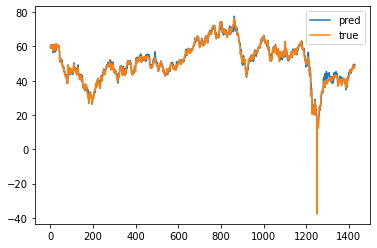

In [50]:
freq='daily'
pca=False
features = feat_1992
regime = no_regime
p_ov_preds, p_ov_errors, p_ov_hyper = regression_models(features, regime, target, freq, pca)

#### Overall, Daily, PCA

PCA reduced features from 41 to 14
Error = 264.56498071750246
data ready
XGBoost Train RMSE =  4.266581930692523
XGBoost Test RMSE =  23.326008363825906


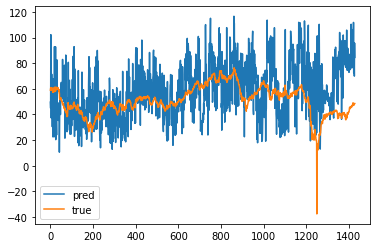

In [51]:
freq='daily'
pca=True
features = feat_1992
regime = no_regime
p_ov_pca_preds, p_ov_pca_errors, p_ov_hyper = regression_models(features, regime, target, freq, pca)

#### Overall, Weekly

data ready
XGBoost Train RMSE =  0.038122926938264814
XGBoost Test RMSE =  3.187125342022564


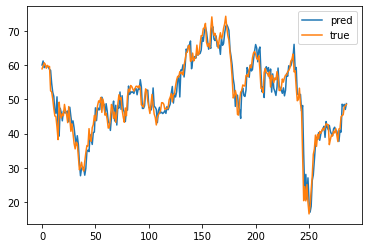

In [52]:
freq='weekly'
pca=False
features = feat_1992
regime = no_regime
w_p_ov_preds, w_p_ov_errors, w_p_ov_hyper = regression_models(features, regime, target, freq, pca)

#### Overall, Weekly, PCA

PCA reduced features from 41 to 14
Error = 111.36100223062545
data ready
XGBoost Train RMSE =  0.27066857410439016
XGBoost Test RMSE =  21.87506116308473


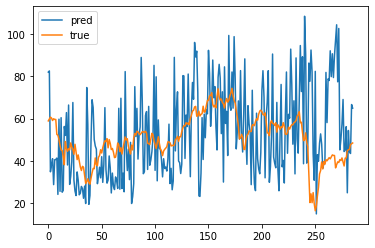

In [53]:
freq='weekly'
pca=True
features = feat_1992
regime = no_regime
w_p_ov_pca_preds, w_p_ov_pca_errors, w_p_ov_pca_hyper = regression_models(features, regime, target, freq, pca)

#### Stacking, Daily, Overall

#### Stacking, Daily, Overall, PCA

#### Stacking, Weekly, Overall

#### Stacking, Weekly, Overall, PCA

#### Regime Based, Daily

In [76]:
freq1 = 'daily'
pca1 = False

Regime 1

data ready
XGBoost Train RMSE =  0.014968616755519802
XGBoost Test RMSE =  0.9049103282952818


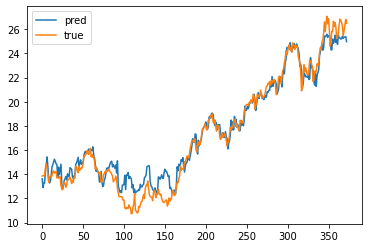

In [55]:
features = feat_1992
regime = reg_92_99
p_r1_preds, p_r1_errors, p_r1_hyper = regression_models(features, regime, target, freq1, pca1)

Regime 2

data ready
XGBoost Train RMSE =  0.04170557562802405
XGBoost Test RMSE =  6.055675739488273


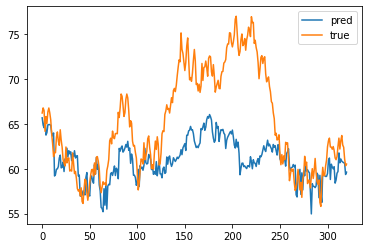

In [77]:
features = feat_2000
regime = reg_00_06
p_r2_preds, p_r2_errors, p_r2_hyper = regression_models(features, regime, target, freq1, pca1)

Regime 3

data ready
XGBoost Train RMSE =  0.06810245249730197
XGBoost Test RMSE =  1.8686033760476564


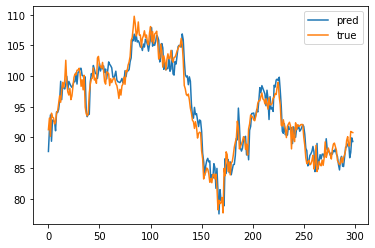

In [57]:
features = feat_2002
regime = reg_07_12
p_r3_preds, p_r3_errors, p_r3_hyper = regression_models(features, regime, target, freq1, pca1)

Regime 4

data ready
XGBoost Train RMSE =  0.07415692215339417
XGBoost Test RMSE =  5.1976991170714255


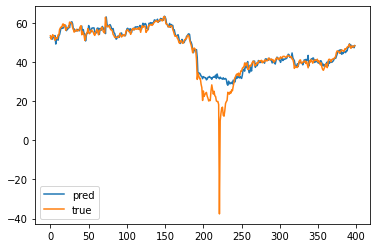

In [58]:
features = feat_2002
regime = reg_13_20
p_r4_preds, p_r4_errors, p_r4_hyper = regression_models(features, regime, target, freq1, pca1)

**With PCA**

In [78]:
pca2=True

Regime 1

PCA reduced features from 41 to 14
Error = 144.81428032308696
data ready
XGBoost Train RMSE =  0.07539497941202036
XGBoost Test RMSE =  4.504206901979132


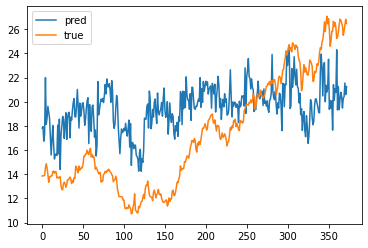

In [60]:
features = feat_1992
regime = reg_92_99
p_r1_pca_preds, p_r1_pca_errors, p_r1_pca_hyper = regression_models(features, regime, target, freq1, pca2)

Regime 2

PCA reduced features from 51 to 17
Error = 131.57831636471417
data ready
XGBoost Train RMSE =  0.12330408225514364
XGBoost Test RMSE =  22.11221482255058


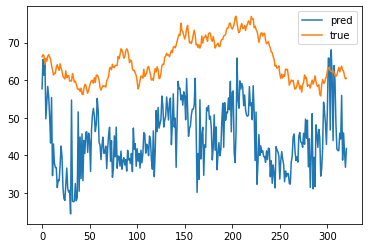

In [79]:
features = feat_2000
regime = reg_00_06
p_r2_pca_preds, p_r2_pca_errors, p_r2_pca_hyper = regression_models(features, regime, target, freq1, pca2)

Regime 3

PCA reduced features from 53 to 18
Error = 107.3549858312069
data ready
XGBoost Train RMSE =  0.1673789812906531
XGBoost Test RMSE =  10.926535621094


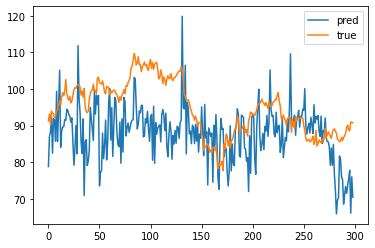

In [62]:
features = feat_2002
regime = reg_07_12
p_r3_pca_preds, p_r3_pca_errors, p_r3_pca_hyper = regression_models(features, regime, target, freq1, pca2)

Regime 4

PCA reduced features from 53 to 18
Error = 134.95893286647615
data ready
XGBoost Train RMSE =  0.27117071711804974
XGBoost Test RMSE =  22.502395257188212


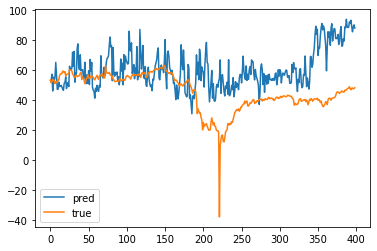

In [63]:
features = feat_2002
regime = reg_13_20
p_r4_pca_preds, p_r4_pca_errors, p_r4_pca_hyper = regression_models(features, regime, target, freq1, pca2)

### Weekly

In [64]:
freq2='weekly'
pca1=False

Regime 1

data ready
XGBoost Train RMSE =  0.001604431422784756
XGBoost Test RMSE =  1.5853410584219383


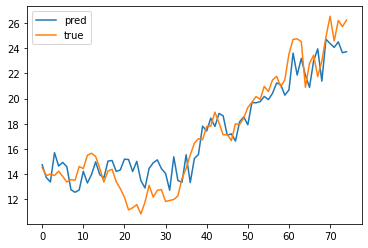

In [65]:
features = feat_1992
regime = reg_92_99
w_p_r1_preds, w_p_r1_errors, w_p_r1_hyper = regression_models(features, regime, target, freq2, pca1)

Regime 2

data ready
XGBoost Train RMSE =  0.007817964968382992
XGBoost Test RMSE =  6.449579274349643


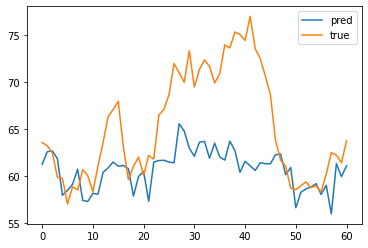

In [66]:
features = feat_2000
regime = reg_00_06
w_p_r2_preds, w_p_r2_errors, w_p_r2_hyper = regression_models(features, regime, target, freq2, pca1)

Regime 3

data ready
XGBoost Train RMSE =  0.0118241809490095
XGBoost Test RMSE =  4.060572863183917


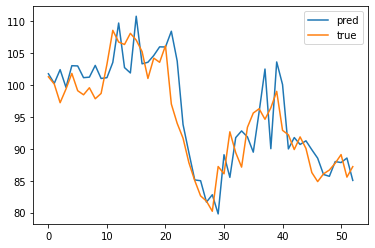

In [83]:
features = feat_2002
regime = reg_07_12
w_p_r3_preds, w_p_r3_errors, w_p_r3_hyper = regression_models(features, regime, target, freq2, pca1)

Regime 4

data ready
XGBoost Train RMSE =  0.020418251313014876
XGBoost Test RMSE =  6.361696088781596


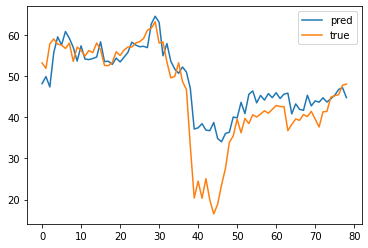

In [87]:
features = feat_2002
regime = reg_13_20
w_p_r4_preds, w_p_r4_errors, w_p_r4_hyper = regression_models(features, regime, target, freq2, pca1)

**With PCA**

In [88]:
pca2=True

Regime 1

PCA reduced features from 41 to 14
Error = 60.553778133780725
data ready
XGBoost Train RMSE =  0.002334632521139344
XGBoost Test RMSE =  5.052667573517088


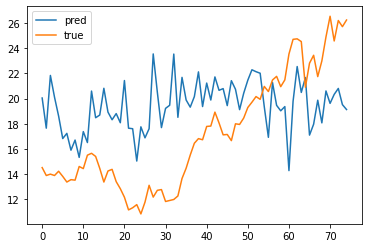

In [70]:
features = feat_1992
regime = reg_92_99
w_p_r1_pca_preds, w_p_r1_pca_errors, w_p_r1_pca_hyper = regression_models(features, regime, target, freq2, pca2)

Regime 2

PCA reduced features from 51 to 17
Error = 52.52126885894225
data ready
XGBoost Train RMSE =  0.010031928998911968
XGBoost Test RMSE =  25.484592375524528


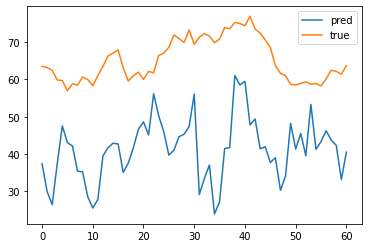

In [71]:
features = feat_2000
regime = reg_00_06
w_p_r2_pca_preds, w_p_r2_pca_errors, w_p_r2_pca_hyper = regression_models(features, regime, target, freq2, pca2)

Regime 3

PCA reduced features from 53 to 18
Error = 40.42100455646233
data ready
XGBoost Train RMSE =  0.015667077059902782
XGBoost Test RMSE =  11.55820416466395


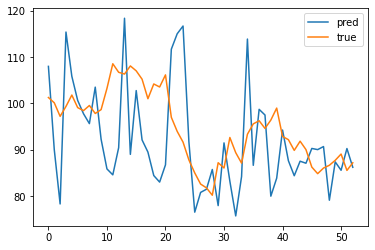

In [89]:
features = feat_2002
regime = reg_07_12
w_p_r3_pca_preds, w_p_r3_pca_errors, w_p_r3_pca_hyper = regression_models(features, regime, target, freq2, pca2)

Regime 4

PCA reduced features from 53 to 18
Error = 56.73000680662295
data ready
XGBoost Train RMSE =  0.026256769705256273
XGBoost Test RMSE =  23.264848122690132


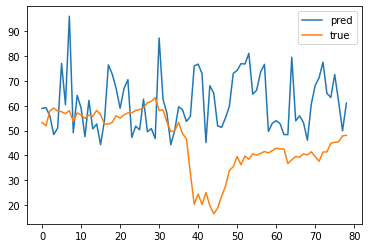

In [90]:
features = feat_2002
regime = reg_13_20
w_p_r4_pca_preds, w_p_r4_pca_errors, w_p_r4_pca_hyper = regression_models(features, regime, target, freq2, pca2)

### Meta and Stacking

In [93]:
features = feat_2002
target = prices
regime = no_regime
freq='daily'
pca=False

df_target, df_features = meta_ready(features, regime, target, freq, pca)

In [96]:
split_data, train_data, test_data = get_data_splits(df_target, df_features)

In [98]:
from sklearn.ensemble import StackingRegressor

level0 = list()
level0.append(('xgb', TransformedTargetRegressor(regressor=xgb.XGBRegressor(n_estimators=100, subsample=1.0)
                                                 , transformer=RobustScaler())))
level0.append(('rf', TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=70), transformer=RobustScaler())))
level0.append(('huber', TransformedTargetRegressor(regressor=linear_model.HuberRegressor(alpha=0.95), transformer=RobustScaler())))
level0.append(('lasso', TransformedTargetRegressor(regressor=linear_model.Lasso(alpha=0.05), transformer=RobustScaler())))
level1 = LinearRegression()

In [99]:
stack_model = StackingRegressor(estimators=level0, final_estimator=level1)
stack_model.fit(train_data[0], train_data[1])
stack_yhat_train = stack_model.predict(train_data[0])
stack_pred = stack_model.predict(test_data[0])
stack_train_rmse = np.sqrt(np.mean((stack_yhat_train - train_data[1])**2))
stack_test_rmse = np.sqrt(np.mean((stack_pred - test_data[1])**2))

print("Stack Train RMSE = ", stack_train_rmse)
print("Stack Test RMSE = ", stack_test_rmse)

Stack Train RMSE =  37.04811900254418
Stack Test RMSE =  17.14029297706816


(50.0, 60.0)

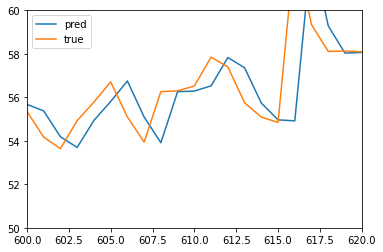

In [102]:
plt.plot(stack_pred, label='pred')
plt.plot(test_data[1], label='true')
plt.legend()
plt.xlim(600, 620)
plt.ylim(50, 60)

In [103]:
models_meta = [0]*4

In [104]:
split_n = int(len(train_data[0])*0.6)

r_train_X = train_data[0][:split_n]
r_train_y = train_data[1][:split_n]

c_train_X = train_data[0][split_n:]
c_train_y = train_data[1][split_n:]

In [105]:
lasso = linear_model.Lasso(alpha=0.05)
models_meta[0] = TransformedTargetRegressor(regressor=lasso, transformer=RobustScaler())
models_meta[0].fit(r_train_X, r_train_y)

TransformedTargetRegressor(regressor=Lasso(alpha=0.05),
                           transformer=RobustScaler())

In [106]:
huber = linear_model.HuberRegressor(alpha=0.95)
models_meta[1] = TransformedTargetRegressor(regressor=huber, transformer=RobustScaler())
models_meta[1].fit(r_train_X, r_train_y)

TransformedTargetRegressor(regressor=HuberRegressor(alpha=0.95),
                           transformer=RobustScaler())

In [107]:
models_meta[2] = RandomForestRegressor(n_estimators=70)
models_meta[2].fit(r_train_X, r_train_y)

RandomForestRegressor(n_estimators=70)

In [108]:
xgb_reg = xgb.XGBRegressor(n_estimators=100, subsample=1.0)
models_meta[3] = TransformedTargetRegressor(regressor=xgb_reg, transformer=RobustScaler())
models_meta[3].fit(r_train_X, r_train_y)

TransformedTargetRegressor(regressor=XGBRegressor(base_score=None, booster=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  gamma=None, gpu_id=None,
                                                  importance_type='gain',
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  

In [109]:
model_num = []
for i, x in enumerate(c_train_X):
    err = []
    for model in models_meta:
#         print(model)
        yhat = model.predict(x.reshape(1,-1))
        err.append((yhat-c_train_y[i])**2)
    model_num.append((np.argmin(err)))

In [110]:
for i in range(len(models_meta)):
    print('Count of ', i, ' is ', model_num.count(i))

Count of  0  is  634
Count of  1  is  27
Count of  2  is  463
Count of  3  is  386


In [111]:
model_label = np.array(model_num)

In [112]:
split = int(0.75*len(c_train_X))
t_train_X = c_train_X[:split]
t_train_y = model_label[:split]
t_val_X = c_train_X[split:]
t_val_y = model_label[split:]

In [113]:
depths = np.arange(2, 10, 1)
scores = []
for depth in depths:
    dtree_model = DecisionTreeClassifier(max_depth = depth).fit(t_train_X, t_train_y)
    dtree_score = dtree_model.score(t_val_X, t_val_y)
    scores.append(dtree_score)
    
best_depth = depths[np.argmax(scores)]
print('Best depth: ', best_depth)

Best depth:  2


In [114]:
dtree_final = DecisionTreeClassifier(max_depth=best_depth).fit(c_train_X, model_label)
model_pred = dtree_final.predict(test_data[0])

In [115]:
meta_preds = []
for i, x in enumerate(test_data[0]):
    pred = models_meta[model_pred[i]].predict(x.reshape(1,-1))
    meta_preds.append(pred)


In [116]:
meta_mse = np.mean((meta_preds-test_data[1])**2)**0.5
meta_mse

2.7326181083772094

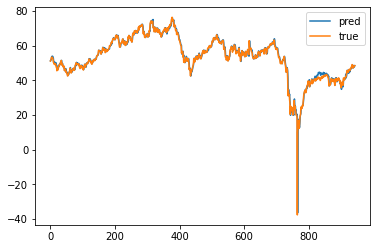

In [117]:
plt.plot(meta_preds, label='pred')
plt.plot(test_data[1], label='true')
plt.legend()
#plt.xlim(800,810)
#plt.ylim(52,58)